Epoch=255 loss=0.029727697372436523


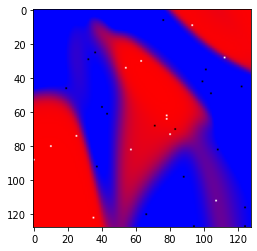

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import pandas as pd
from torch import optim


class SimpleNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        hidden_dimensions = 16
        self.input = nn.Linear(in_features=2, out_features=hidden_dimensions)
        self.hidden_1 = nn.Linear(
            in_features=hidden_dimensions, out_features=hidden_dimensions)
        self.hidden_2 = nn.Linear(
            in_features=hidden_dimensions, out_features=hidden_dimensions)
        self.hidden_3 = nn.Linear(
            in_features=hidden_dimensions, out_features=hidden_dimensions)
        self.output = nn.Linear(in_features=hidden_dimensions, out_features=1)

        # Initialize weights to random with normal distribution
        nn.init.normal_(self.input.weight,    mean=0.0, std=1.0)
        nn.init.normal_(self.hidden_1.weight, mean=0.0, std=1.0)
        nn.init.normal_(self.hidden_2.weight, mean=0.0, std=1.0)
        nn.init.normal_(self.hidden_3.weight, mean=0.0, std=1.0)
        nn.init.normal_(self.output.weight,   mean=0.0, std=1.0)

    def forward(self, xy):
        v = torch.tanh(self.input(xy))
        v = torch.tanh(self.hidden_1(v))
        v = torch.tanh(self.hidden_2(v))
        v = torch.tanh(self.hidden_3(v))
        return torch.tanh(self.output(v))


N = 1 << 5
random_points_x = torch.rand((N))
random_points_y = torch.rand((N))
target_classes = (torch.rand((N)) > 0.5) * 1.0 # 2 classes: [0.0, 1.0] 1.0 if rand() > 0.5 else 0.0
random_points = torch.transpose(
    torch.cat((random_points_x.view(1, N), random_points_y.view(1, N)), 0), 0, 1)


num_epochs = 1 << 8

model = SimpleNetwork().cpu()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
isize = 128

import shutil
import os

try:
    shutil.rmtree('.scratch')
except:
    pass
os.mkdir('.scratch')

def evaluate():
    # Evaluate
    results = np.zeros((isize, isize, 4), dtype=np.uint8)
    for y in range(0, isize):
        for x in range(0, isize):
            predicted_class = model(torch.tensor(
                [(float(x) + 0.5) / isize, (float(y) + 0.5) / isize]))
            c = predicted_class.detach().cpu().clamp(0.0, 1.0).numpy()[0]
            results[y][x][0] = int((c) * 255.0)
            results[y][x][1] = 0
            results[y][x][2] = int((1.0 - c) * 255.0)
            results[y][x][3] = 255

    for i, (fx, fy) in enumerate(zip(random_points_x, random_points_y)):
        x = int(fx * isize)
        y = int(fy * isize)
        c = 1.0 - target_classes[i]
        results[y][x][0] = int((1.0 - c) * 255.0)
        results[y][x][1] = int((1.0 - c) * 255.0)
        results[y][x][2] = int((1.0 - c) * 255.0)
        results[y][x][3] = 255
    return results

from matplotlib import pyplot as plt

def dump_image(id):
    out = evaluate()
    # out = out.clamp(0.0, 1.0)
    plt.imsave(".scratch/out_" + str(id) + ".png", out)


for epoch in range(0, num_epochs):
    for i in range(0, N):
        point = random_points[i]
        target_class = target_classes[i]
        predicted_class = model(point)
        loss = (predicted_class - target_class).square().mean().sqrt()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    dump_image(epoch)
    # print(f"Epoch={epoch} loss={loss}")
print(f"Epoch={epoch} loss={loss}")

results = evaluate()
plt.figure()
plt.imshow(results)
# plt.scatter(x=random_points_x * isize, y=random_points_y * isize, c=(1.0 - target_classes), s=40)

In [16]:
from moviepy.editor import *
import cv2
fourcc = cv2.VideoWriter_fourcc(*"H264")
video = cv2.VideoWriter("nn_video_1.mp4", fourcc, 24, (isize, isize))
gen = {}
for n in range(0, num_epochs):
    image = cv2.imread(f".scratch/out_" + str(n) + ".png")
    video.write(image)
video.release()